In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
general = 'Erdos'
tipo = "scalefree_MDH_Erdos"
subfijo = "_SME"

In [47]:
"""
EME: GRAT > MDH > GAT
EIE: MDH > SAGE > GRAT 

** GAT es muy mala heurística pura y sage muy buena

SIE: MDH > GRAT > SAGE
SME: GRAT > MDH > GAT


EMS: 
SMS: 
SIS:
EIS:
""";

In [83]:
FastCover = pd.read_csv(f"FastCover/results/{tipo}/FCResults{subfijo}.txt", header = None)
#FastCover = pd.read_csv("FastCover/results/paper/FastCoverResults_MDH_erdos.txt", header = None)
FastCover.columns = ["graph", "target_size","t_mean","n"]
FastCover["model"] = "GRAT"
FastCover = FastCover[["graph", "model","target_size", "n", "t_mean"]]
FastCover.head()

,graph,model,target_size,n,t_mean
0,ER_10000_10_0,GRAT,1633,10000,0.071
1,ER_10000_10_1,GRAT,1607,10000,0.070
2,ER_10000_15_0,GRAT,1971,10000,0.090
3,ER_10000_15_1,GRAT,1995,10000,0.081
4,ER_10000_20_0,GRAT,2224,10000,0.122


In [84]:
models = ['GAT', "GCN", "GraphConv", "SAGE", "SGConv"]
Full = pd.DataFrame()

for model in models:
    
    GNN = pd.read_csv(f"Models/results/{tipo}/{model}Results{subfijo}.txt", header = None)
    #GNN = pd.read_csv(f"Models/results/paper/{model}Results_MDH_erdos.txt", header = None)
    
    GNN.columns = ["graph", "target_size","t_mean","n"]
    GNN["model"] = model
    GNN = GNN[["graph", "model","target_size", "n", "t_mean"]]
    
    Full = pd.concat([Full, GNN])
    
print(Full.shape)
Full.head()

(90, 5)


,graph,model,target_size,n,t_mean
0,ER_10000_10_0,GAT,1793,10000,0.074
1,ER_10000_10_1,GAT,1657,10000,0.079
2,ER_10000_15_0,GAT,2141,10000,0.104
3,ER_10000_15_1,GAT,2342,10000,0.124
4,ER_10000_20_0,GAT,2574,10000,0.145


In [85]:
MDH = pd.read_csv(f"MDH/MDH_{general}_Results.txt", header = None)
MDH.columns = ["graph", "target_size","t_mean","n"]
MDH["model"] = 'MDH'
MDH = MDH[["graph", "model","target_size", "n", "t_mean"]]
print(MDH.shape)
MDH.head()

(18, 5)


,graph,model,target_size,n,t_mean
0,ER_10000_10_0,MDH,1617,10000,0.065
1,ER_10000_10_1,MDH,1618,10000,0.069
2,ER_10000_15_0,MDH,1980,10000,0.099
3,ER_10000_15_1,MDH,1962,10000,0.091
4,ER_10000_20_0,MDH,2274,10000,0.114


In [86]:
Full = pd.concat([Full, MDH, FastCover])
Full['ratio'] =  Full.target_size/Full.n

In [87]:
#Full = Full.sort_values(by=['n'])
Full = Full.reset_index()
Full

,index,graph,model,target_size,n,t_mean,ratio
0,0,ER_10000_10_0,GAT,1793,10000,0.074,0.179300
1,1,ER_10000_10_1,GAT,1657,10000,0.079,0.165700
2,2,ER_10000_15_0,GAT,2141,10000,0.104,0.214100
3,3,ER_10000_15_1,GAT,2342,10000,0.124,0.234200
4,4,ER_10000_20_0,GAT,2574,10000,0.145,0.257400
...,...,...,...,...,...,...,...
121,13,ER_30000_15_0,GRAT,5952,30000,0.535,0.198400
122,14,ER_30000_20_0,GRAT,6713,30000,0.696,0.223767
123,15,ER_50000_10_0,GRAT,14685,50000,5.275,0.293700
124,16,ER_50000_15_0,GRAT,9897,50000,1.351,0.197940


In [88]:
Full['target_size_diff'] = ( np.array(Full.target_size) - np.tile(MDH.target_size, 7) )

In [89]:
Full.model.count()

126

In [90]:
fig = px.histogram(Full, x="graph", y="target_size",
             color='model', barmode='group',
             height=400)
fig.show()

In [91]:
fig = px.histogram(Full, x="graph", y="target_size_diff",
             color='model', barmode='group',
             height=400)
fig.show()

In [92]:
Full.groupby(by = "model").mean().sort_values(by=['ratio'])

C:\Users\Jairo Enrique\AppData\Local\Temp\ipykernel_13412\1843624887.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,index,target_size,n,t_mean,ratio,target_size_diff
model,,,,,,
MDH,8.5,4724.111111,23333.333333,0.578278,0.198539,0.000000
SAGE,8.5,4751.666667,23333.333333,0.496000,0.198773,27.555556
SGConv,8.5,4736.277778,23333.333333,0.484944,0.199005,12.166667
GCN,8.5,4766.611111,23333.333333,0.529722,0.199956,42.500000
GRAT,8.5,4897.222222,23333.333333,0.673889,0.201512,173.111111
GraphConv,8.5,4896.722222,23333.333333,0.522833,0.203382,172.611111
GAT,8.5,4874.944444,23333.333333,0.509167,0.209059,150.833333


In [93]:
print(Full.shape)
Full_ = Full.drop_duplicates(subset=['target_size'], keep = False)
Full_.shape

(126, 8)


(122, 8)

In [94]:
Full_.query(f"graph == '{Full_.graph.unique()[-1]}'").sort_values(by = ['target_size'])

,index,graph,model,target_size,n,t_mean,ratio,target_size_diff
125,17,ER_50000_20_0,GRAT,11146,50000,1.634,0.22292,-71
71,17,ER_50000_20_0,SAGE,11209,50000,1.747,0.22418,-8
107,17,ER_50000_20_0,MDH,11217,50000,2.005,0.22434,0
89,17,ER_50000_20_0,SGConv,11234,50000,1.732,0.22468,17
35,17,ER_50000_20_0,GCN,11251,50000,1.980,0.22502,34
17,17,ER_50000_20_0,GAT,11327,50000,1.807,0.22654,110
53,17,ER_50000_20_0,GraphConv,11480,50000,1.860,0.22960,263


## Por mejor solución

In [95]:
models_name = Full_.model.unique()
Dict = {m: i for m, i in zip(models_name, np.arange(models_name.shape[0]))}

MT = np.zeros((models_name.shape[0], models_name.shape[0]))
for graph in Full_.graph.unique():
    
    Temp = np.array(Full_.query(f"graph == '{graph}'").sort_values(by = "ratio", ascending = False).model)
    
    for m in range(Temp.shape[0]):

        if (m + 1) == Temp.shape[0]:
            MT[ Dict[ Temp[m] ] ][ Dict[ Temp[m] ] ] += 1
            continue
        
        for j in range(m + 1, Temp.shape[0]):
            MT[ Dict[ Temp[m] ] ][ Dict[ Temp[j] ] ] += 1
        

MT_ = MT / np.expand_dims(np.sum(MT, axis = 1), 1)
# La por filas siempre debe de dar 1 y para la probabilidad de estado estacionario, 
# se hace la transpuesta, es decir, las columnas son las deben sumar 1
MT_.sum(1)

array([1., 1., 1., 1., 1., 1., 1.])

In [96]:
SPD_best = np.ones(MT_.shape[0])/MT_.shape[0] # initial distirbution
for _ in range(200):
    SPD_best = np.dot(MT_.T, SPD_best)
print(np.round(SPD_best,5), '\n',models_name)

[0.10646 0.06399 0.04679 0.21455 0.11711 0.16771 0.2834 ] 
 ['GAT' 'GCN' 'GraphConv' 'SAGE' 'SGConv' 'MDH' 'GRAT']


In [97]:
# Obtenemos el mínimo porque 
models_name[np.argsort(-SPD_best)]

array(['GRAT', 'SAGE', 'MDH', 'SGConv', 'GAT', 'GCN', 'GraphConv'],
      dtype=object)

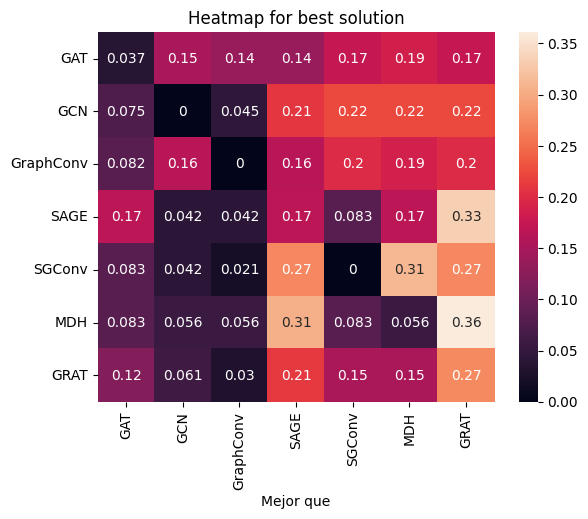

In [98]:
sns.heatmap(MT_, annot = True, xticklabels = models_name, yticklabels = models_name)
plt.title("Heatmap for best solution")
plt.xlabel("Mejor que");

## Por tiempo

In [197]:
MT = np.zeros((models_name.shape[0], models_name.shape[0]))
for graph in Full_.graph.unique():
    Temp = np.array(Full_.query(f"graph == '{graph}'").sort_values(by = "t_mean", ascending=False).model)
    for m in range(Temp.shape[0]):

        if (m + 1) == Temp.shape[0]:
            MT[ Dict[ Temp[m] ] ][ Dict[ Temp[m] ] ] += 1
            continue
        MT[ Dict[ Temp[m] ] ][ Dict[ Temp[m + 1] ] ] += 1

MT_ = MT / np.expand_dims(np.sum(MT, axis = 1), 1)
# La por filas siempre debe de dar 1 y para la probabilidad de estado estacionario, 
# se hace la transpuesta, es decir, las columnas son las deben sumar 1
MT_.sum(1)

array([1., 1., 1., 1., 1., 1.])

In [198]:
SPD_time = np.ones(MT_.shape[0])/MT_.shape[0] # initial distirbution
for _ in range(100):
    SPD_time = np.dot(MT_.T, SPD_time)
print(np.round(SPD_time,5), '\n',models_name)

[0.25908 0.08006 0.02947 0.22456 0.13889 0.26794] 
 ['GAT' 'GCN' 'GraphConv' 'SAGE' 'MDH' 'GRAT']


In [199]:
models_name[np.argsort(-SPD_time)]

array(['GRAT', 'GAT', 'SAGE', 'MDH', 'GCN', 'GraphConv'], dtype=object)

Text(0.5, 1.0, 'Heatmap for fastest solution')

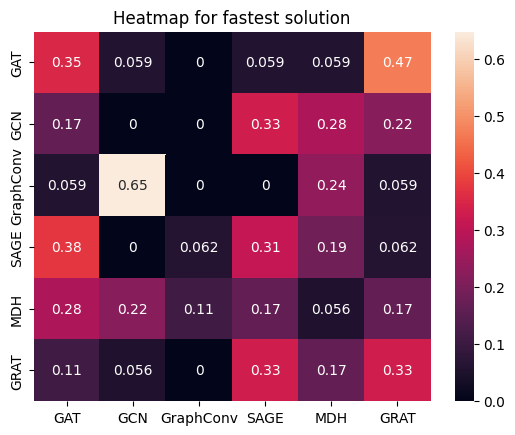

In [200]:
sns.heatmap(MT_, annot = True, xticklabels = models_name, yticklabels = models_name)
plt.title("Heatmap for fastest solution")

## All together

In [99]:
print("---- Best solution ----\n")
c = 1
for g in np.argsort(-SPD_best):
    print(c," - ", models_name[g][:6], f" \t {SPD_best[g]:.3f}")
    c += 1

---- Best solution ----

1  -  GRAT  	 0.283
2  -  SAGE  	 0.215
3  -  MDH  	 0.168
4  -  SGConv  	 0.117
5  -  GAT  	 0.106
6  -  GCN  	 0.064
7  -  GraphC  	 0.047


In [202]:
print("------ Best time ------\n")
c = 1
for g in np.argsort(-SPD_time):
    print(c," - ", models_name[g][:6], f" \t {SPD_time[g]:.3f}")
    c+=1

------ Best time ------

1  -  GRAT  	 0.268
2  -  GAT  	 0.259
3  -  SAGE  	 0.225
4  -  MDH  	 0.139
5  -  GCN  	 0.080
6  -  GraphC  	 0.029


In [301]:
import numpy as np
x = np.array([[6.5,7], [5,3],[6,6],[7.5,8.2],[4,4], [6,7], [5,5], [5.1,5.2], [7,8], [8,8], [8,8]])
x = np.append(np.ones((11,1)),x, axis = 1)
y = np.array([6,8,7,2.5,4,10,5,7,4,12,4])

In [3]:
x

array([[1. , 6.5, 7. ],
       [1. , 5. , 3. ],
       [1. , 6. , 6. ],
       [1. , 7.5, 8.2],
       [1. , 4. , 4. ],
       [1. , 6. , 7. ],
       [1. , 5. , 5. ],
       [1. , 5.1, 5.2],
       [1. , 7. , 8. ],
       [1. , 8. , 8. ],
       [1. , 8. , 8. ]])

In [4]:
np.dot(x.T, x)

array([[ 11.  ,  68.1 ,  69.4 ],
       [ 68.1 , 439.51, 451.52],
       [ 69.4 , 451.52, 470.28]])

In [73]:
np.linalg.inv(np.dot(x.T, x))

array([[ 2.50477748, -0.61285329,  0.21877171],
       [-0.61285329,  0.31657017, -0.21350205],
       [ 0.21877171, -0.21350205,  0.1748271 ]])

In [74]:
np.dot(x.T,y)

array([ 69.5 , 432.45, 435.9 ])

In [5]:
B = np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T,y))
B

array([ 4.41621859,  1.24192201, -0.91719443])

In [80]:
SST = np.dot(y,y) - (np.sum(y)**2)/11
SST

82.13636363636363

In [84]:
np.dot(B, np.dot(x.T,y))

444.19131364903933

In [81]:
SSE = np.dot(y,y) - np.dot(B, np.dot(x.T,y))
SSE

77.05868635096067

In [83]:
SSReg = SST - SSE
SSReg

5.077677285402956

In [90]:
np.dot(B, [1,10,10])

7.663494397900552

In [15]:
import torch
torch.sigmoid(torch.tensor([100]))

tensor([1.])